-------------
### ライブラリのインポート＆その他の設定（Importing Libraries & Other Settings）

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# シード設定
# from lightning.pytorch import seed_everything
# seed_everything(8)

# 可視化の設定
import matplotlib.pyplot as plt
from matplotlib import cm
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

--------
### 実験設定

In [2]:
TARGET = "visit"  #'conversion', 'visit'
TRAIN_SIZE = 100000
TEST_SIZE = 100000

RANDOM_STATE = 0  # 乱数シード
N_CLUSTERS = 10
K_MIN = 2
K_MAX = 10

-----------
### データの前処理（Data Preprocessing）

In [4]:
df_all = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\criteo-uplift-v2.1.csv.gz", sep=",", header=None
)

df_all.columns = df_all.iloc[0]  # 0行目を列名にする
df_all = df_all[1:].reset_index(drop=True)

column_names = df_all.columns.tolist()
print("列名:", column_names)

df_treatment = df_all[df_all["treatment"] == 1]
df_treatment_0 = df_treatment[df_treatment[TARGET] == 0]
df_treatment_1 = df_treatment[df_treatment[TARGET] == 1]
print(df_treatment.shape)
print(df_treatment_0.shape)
print(df_treatment_1.shape)

features_list = [
    "f0",
    "f1",
    "f2",
    "f3",
    "f4",
    "f5",
    "f6",
    "f7",
    "f8",
    "f9",
    "f10",
    "f11",
]
ALL_FEATURES_INDEX = [i for i in range(len(features_list))]

df_train_0 = df_treatment_0.iloc[: int(TRAIN_SIZE / 2)]
df_train_1 = df_treatment_1.iloc[: int(TRAIN_SIZE / 2)]
df_test_0 = df_treatment_0.iloc[
    int(TRAIN_SIZE / 2) : int(TRAIN_SIZE / 2 + TEST_SIZE / 2)
]
df_test_1 = df_treatment_1.iloc[
    int(TRAIN_SIZE / 2) : int(TRAIN_SIZE / 2 + TEST_SIZE / 2)
]

df_train = pd.concat([df_train_0, df_train_1])
df_test = pd.concat([df_test_0, df_test_1])
print(df_train.shape)
print(df_test.shape)


C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_1996\1855434516.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(


列名: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'treatment', 'conversion', 'visit', 'exposure']
(11849888, 16)
(11273895, 16)
(575993, 16)
(100000, 16)
(100000, 16)


In [5]:
X_train = df_train[features_list].to_numpy()
y_train = df_train[TARGET].to_numpy()

X_test = df_test[features_list].to_numpy()
y_test = df_test[TARGET].to_numpy()

In [6]:
sc = StandardScaler()
# 訓練データに基づいてfit
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

-------------
### Kmeansのクラスタ数確認

In [7]:
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE)
labels = kmeans.fit_predict(X_test_std)
cluster_size = np.bincount(labels)

print(cluster_size)

[ 7169  5432  2221 38228 16118  3838  4132  7732  6522  8608]


-------------
### Xmeans で確認

##### Xmeans

In [9]:
def compute_bic(X, kmeans):
    labels = kmeans.labels_
    clusters = kmeans.cluster_centers_
    n_clusters = len(clusters)
    n = len(X)
    m = X.shape[1]
    variance = np.sum(
        [
            np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
            for i in range(n_clusters)
        ]
    )
    bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
    return bic


def xmeans(X, k_min=2, k_max=10):
    kmeans = KMeans(n_clusters=k_min, random_state=RANDOM_STATE)
    kmeans.fit(X)
    best_bic = compute_bic(X, kmeans)
    best_k = k_min
    score_dict = {}
    score_dict[k_min] = best_bic
    for k in range(k_min + 1, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        kmeans.fit(X)
        current_bic = compute_bic(X, kmeans)
        score_dict[k] = current_bic
        if current_bic < best_bic:
            best_bic = current_bic
            best_k = k
    return best_k, score_dict

##### クラスタリング結果

n_clusters chosen in Xmeans: 10


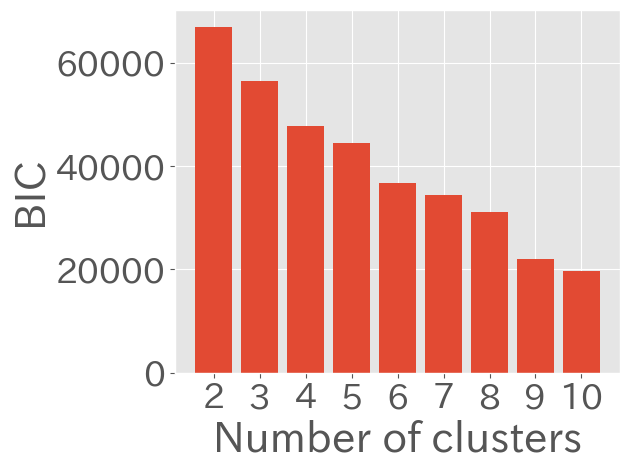

In [10]:
best_k, score_dict = xmeans(X_train_std, k_min=K_MIN, k_max=K_MAX)
print("n_clusters chosen in Xmeans:", best_k)

x = []
for k in score_dict.keys():
    x.append(str(k))
y = [score for score in score_dict.values()]
bars = plt.bar(x, y)
plt.ylabel("BIC", fontsize=30)
plt.xlabel("Number of clusters", fontsize=30)
plt.tick_params(axis="both", which="major", labelsize=25)
plt.tight_layout()
plt.show()

-----------------------------
### シルエット係数で確認

In [8]:
def silhouette(X, k_min=2, k_max=10):
    kmeans = KMeans(n_clusters=k_min, random_state=RANDOM_STATE)
    kmeans.fit(X)
    labels = kmeans.predict(X)
    best_score = silhouette_score(X, labels)
    score_dict = {}
    score_dict[k_min] = best_score
    best_k = k_min
    for k in range(k_min + 1, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        kmeans.fit(X)
        labels = kmeans.predict(X)
        current_score = silhouette_score(X, labels)
        score_dict[k] = current_score
        if current_score > best_score:
            best_score = current_score
            best_k = k
    return best_k, score_dict

##### 結果

In [ ]:
best_k, score_dict = silhouette(X_train_std, k_min=K_MIN, k_max=K_MAX)
print("n_clusters chosen in Xmeans:", best_k)

x = []
for k in score_dict.keys():
    x.append(str(k))
y = [score for score in score_dict.values()]
bars = plt.bar(x, y)
plt.ylabel("Silhouette score", fontsize=30)
plt.xlabel("Number of clusters", fontsize=30)
plt.tick_params(axis="both", which="major", labelsize=25)
plt.tight_layout()
plt.show()

In [13]:
print(score_dict)

{2: 0.5248087074627189, 3: 0.5103192480055939, 4: 0.5398580593509058, 5: 0.5478263979203715, 6: 0.5710550597808189, 7: 0.5756617998793672, 8: 0.5800034096882729, 9: 0.4495667235699464, 10: 0.45004305841160547}


### シルエット図

In [14]:
def plot_silhouette_diagram(n_clusters: int, X):
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE)
    labels = kmeans.fit_predict(X)
    cluster_labels = np.unique(labels)
    n_clusters = cluster_labels.shape[0]

    silhouette_vals = silhouette_samples(X, labels, metric="euclidean")
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[labels == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(
            range(y_ax_lower, y_ax_upper),
            c_silhouette_vals,
            height=1.0,
            edgecolor="none",
            color=color,
        )
        yticks.append((y_ax_lower + y_ax_upper) / 2.0)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel("Cluster", fontsize=30)
    plt.xlabel("Silhouette coefficient", fontsize=30)
    plt.tick_params(axis="both", which="major", labelsize=25)
    plt.xlim(-0.6, 0.6)
    plt.tight_layout()
    plt.show()

In [15]:
# for n_clusters in range(K_MIN, K_MAX + 1):
#     plot_silhouette_diagram(n_clusters=n_clusters, X=X_train_std)

-----
## エルボー図

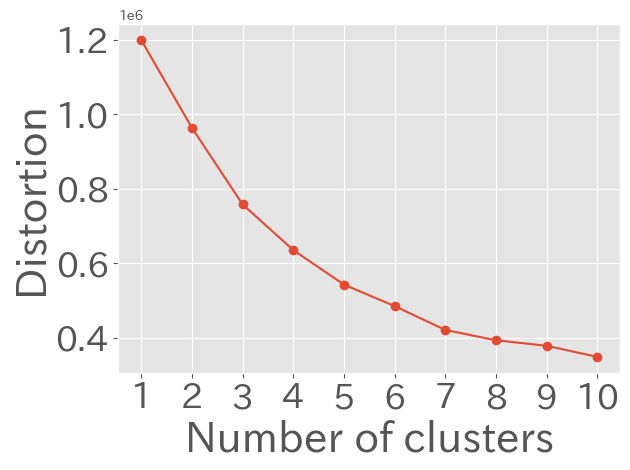

In [16]:
distortions = []
for i in range(K_MIN - 1, K_MAX + 1):
    kmeans = KMeans(n_clusters=i, random_state=RANDOM_STATE)
    kmeans.fit(X_train_std)
    distortions.append(kmeans.inertia_)

plt.plot(range(K_MIN - 1, K_MAX + 1), distortions, marker="o")
plt.xlabel("Number of clusters", fontsize=30)
plt.ylabel("Distortion", fontsize=30)
plt.xticks(range(K_MIN - 1, K_MAX + 1))
plt.tick_params(axis="both", labelsize=25)
plt.tight_layout()
plt.show()